In [7]:
import numpy as np
import casadi as ca

import matplotlib as plt
import matplotlib.cm as cm
import matplotlib.pyplot as plt

$p^{*}$ is a global solution of the trust-region problem iff

$\begin{aligned}(B+\lambda I) p^{*} &=-g \\ \lambda\left(\Delta-\left\|p^{*}\right\|\right) &=0\\ 
(B+\lambda I) &\quad \text{is positive semidefinite.}\end{aligned}$

In [8]:
def create_subproblem(f_func,Nx):
    x = ca.SX.sym("x",Nx)
    p = ca.SX.sym("p",Nx)
    f = f_func(x)
    delta_k = ca.SX.sym("delta_k",1)
    
    grad = ca.SX.sym('grad',Nx)
    H = ca.SX.sym('H',Nx,Nx)
    
    obj = f + grad.T @ p + 1/2 * p.T @ H @ p
    g = ca.norm_2(p) - delta_k
#     g = p.T @ p - delta_k ** 2    
    para = ca.vertcat(delta_k, x,ca.reshape(grad,-1,1),ca.reshape(H,-1,1))
    
    solver_opt = {}
    solver_opt['print_time'] = False
    solver_opt['ipopt'] = {
        'max_iter': 500,
        'print_level': 1,
        'acceptable_tol': 1e-9,
        'acceptable_obj_change_tol': 1e-9
    }
    nlp = {'x':p, 'g':g, 'f':obj, 'p': para}
    solver = ca.nlpsol('solver', 'ipopt', nlp, solver_opt)
    return solver

#### Cauchy point
The minimizer of $m_{k}$ along the **steepest descent** direction $-g_{k}$, subject to the trust-region bound. It is an approximate solution which gives a sufficient reduction in the model and solves a linear version of the subproblem.

Closed-form solution:$p_{k}^{\mathrm{C}}=-\tau_{k} \frac{\Delta_{k}}{\left\|g_{k}\right\|} g_{k}$

In [13]:
def cauchy_point_method(Nx, delta_k, gk, Bk):
        
    # Consider either B is positive definite or negative definite.

    
    B_pos = (gk.T @ Bk @ gk > 0)
    if B_pos is True:
        tau_k = 1
    else:
        tau_k = ca.fmin(ca.norm_2(gk) ** 3, 1)
        
    p_cauchy = - tau_k * delta_k / ca.norm_2(gk) * gk

#### Dogleg method
It is used when $B$ is positive definite. The dogleg method chooses $p$ to minimize the model $m$ along this path, subject to the trust-region bound.

$\tilde{p}(\tau)=\left\{\begin{array}{ll}\tau p^{\mathrm{U}}, & 0 \leq \tau \leq 1 \\ p^{\mathrm{U}}+(\tau-1)\left(p^{\mathrm{B}}-p^{\mathrm{U}}\right), & 1 \leq \tau \leq 2\end{array}\right.$, where $p^{\mathrm{B}}=-B^{-1} g$ and $p^{\mathrm{U}}=-\frac{g^{T} g}{g^{T} B g} g$

And compute an appropirate $\tau$ by
$\left\|p^{\mathrm{U}}+(\tau-1)\left(p^{\mathrm{B}}-p^{\mathrm{U}}\right)\right\|^{2}=\Delta^{2}$

In [ ]:
# def dogleg_method(Nx, delta_k, gk, Bk):
#     pB = ca.inv(Bk) @ gk
#     pU = - (gk.t @ g) / (gk.T @ Bk @ gk ) * gk 
    
    

In [ ]:
# def two_d_subspace_min():

In [9]:
Nx = 2
N_iter = 10
x_lim = 10
y_lim = 10
delta = 1
delta_ub = 1
delta_0 = delta_ub / 2
eta = 0.1

x_init = ca.DM([2.5,2.5])

# diag_1 = 1
# diag_2 = 10
x_SX = ca.SX.sym('x',Nx)
p_SX = ca.SX.sym('p',Nx)
# Hq = ca.diag([diag_1,diag_2])
# f = x_SX.T @ Hq @ x_SX
f = x_SX[0] ** 2 + ca.sin(x_SX[1]) 

f_func = ca.Function("f_func",[x_SX],[f])
H,g = ca.hessian(f,x_SX)

grad_func = ca.Function("grad_func", [x_SX],[g])
hessian_func = ca.Function("hessian_func", [x_SX],[H])

mk = f + g.T @ p_SX + 1/2 * p_SX.T @ H @ p_SX
mk_func = ca.Function("mk_func",[p_SX, x_SX],[mk])

In [10]:
subprob_solver = create_subproblem(f_func,Nx)
nl_qp = {}

xk = x_init
p0 = ca.DM.zeros(Nx)
delta_k = delta_0

nl_qp['lbg'] = [-ca.inf]
nl_qp['ubg'] = [0]
nl_qp['lbx'] = [-np.inf] * Nx
nl_qp['ubx'] = [+np.inf] * Nx

x_sol_list = []
x_sol_list += x_init.full().flatten().tolist()
for i in range(N_iter):
    Hk = hessian_func(xk)
    gk = grad_func(xk)
    
    nl_qp['x0'] = xk
    nl_qp['p'] = ca.vertcat(delta_k, xk, ca.reshape(gk,-1,1),ca.reshape(Hk,-1,1))
    p_sol = subprob_solver(**nl_qp)['x']
    xk_next = xk + p_sol

    rho_k = ( f_func(xk) - f_func(xk_next) )/ ( mk_func(p0,xk) -  mk_func(p_sol,xk) )
    print(p_sol.T @ p_sol )
    if rho_k < 1/4:
        delta_k_next = 1/4 * delta_k
    else:
        if rho_k > 3/4 and p_sol.T @ p_sol == delta_k:
            delta_k_next = ca.fmin(2*delta_k, delta_ub)
        else:
            delta_k_next = delta_k
    if rho_k > eta:
        xk_next = xk + p_sol
    else:
        xk_next = xk
    x_sol_list += xk_next.full().flatten().tolist()
    xk = xk_next

    delta_k = delta_k_next

0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.015646
3.75248e-07
1.58673e-22


In [11]:
x_sol_list

[2.5,
 2.5,
 2.0111502431576778,
 2.6050044028876993,
 1.532852640597537,
 2.7507144320648047,
 1.079550655425711,
 2.9617057095767447,
 0.6817268981814615,
 3.2645856638623085,
 0.372187485759784,
 3.6572501008439398,
 0.15562869868106233,
 4.107918824230729,
 0.023501624920670816,
 4.590145357046481,
 2.5588275248678016e-10,
 4.713001555521108,
 2.61286870232197e-18,
 4.7123889803970345,
 2.61286870232197e-18,
 4.7123889803970345]

-1


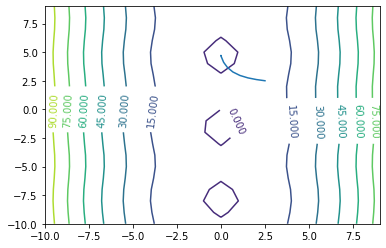

In [12]:
# levels = np.arange(-1,1,0.25)

x = np.arange(-x_lim, x_lim, delta)
y = np.arange(-y_lim, y_lim, delta)
X, Y = np.meshgrid(x, y)
Z = X **2 + np.sin(Y) 
fig, ax = plt.subplots()
x1 = x_sol_list[::2]
x2 = x_sol_list[1::2]
ax.plot(x1,x2)
# CS = ax.contour(X, Y, Z,levels=levels)
CS = ax.contour(X, Y, Z)
ax.clabel(CS, inline=1, fontsize=10)
print(f_func([x1[-1],x2[-1]]))